# FILM_ROI_Modeling

In [1]:
from __future__ import print_function

import pandas as pd
import numpy as np

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score

from scipy.stats import normaltest
from scipy.stats import shapiro
from scipy.stats import anderson
from scipy.stats import probplot

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import power_transform

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing

import statsmodels.api as sm
from patsy import dmatrices

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import regression

import pickle

## Import Pickles

### Full Feature Engineered df = df_full
- No dropped rows or transformations

In [2]:
df_full_in = open('./pickles/feature_engineered_full_df.pkl', 'rb')
df_full = pickle.load(df_full_in)
df_full_in.close()

### Feature Engineered, Curated, Transformed df = df

In [3]:
df_in = open('./pickles/feature_engineered_curated_df.pkl', 'rb')
df = pickle.load(df_in)
df.reset_index(drop=True, inplace=True) 
df_in.close()

### Dictionary of feature descriptions

In [4]:
feature_dict_engineered_in = open('./pickles/feature_dict_engineered.pkl', 'rb')
feature_dict_engineered = pickle.load(feature_dict_engineered_in)
feature_dict_engineered_in.close()

### Change Sci-Fi to SciFi for dmatrices formula

In [5]:
df.rename(columns = {'Sci-Fi': 'SciFi'}, inplace=True)

## StatsModels
- Use StatsModels to do a quick evaluation of the uncurated features and target

### Basic Model
- Model that uses all variables without transformations. Just throwing everything in.
- Mostly doing this out of curiosity. We know about multicollinearity and non-normality in the data. We will be addressing them moving forward. 

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     111.1
Date:                Sun, 03 Nov 2019   Prob (F-statistic):               0.00
Time:                        16:22:20   Log-Likelihood:                -1179.7
No. Observations:                1419   AIC:                             2417.
Df Residuals:                    1390   BIC:                             2570.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0545      0.074     -0.737

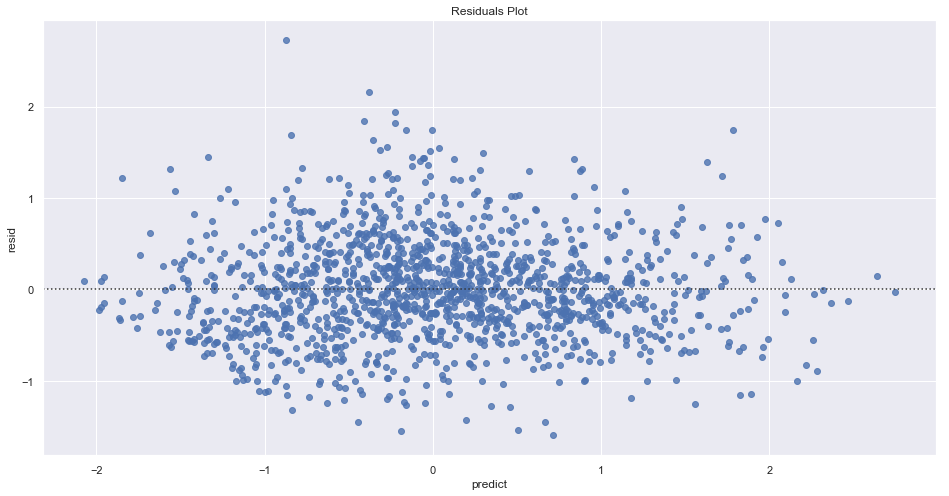

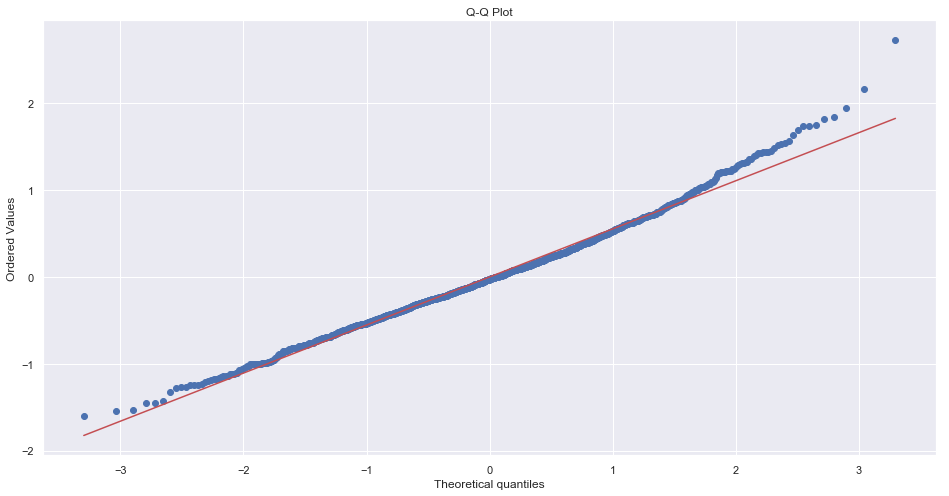


Shapiro-Wilk Test Results
Statistics: 0.99, P-Value: 0.0
Data does not look normal (Reject H0)

D'Agostino/Pearson Test Results
Statistics: 57.304, P-Value: 0.0
Data does not look normal (Reject H0)

Anderson-Darling Test Results
Statsistic: 2.943
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.785, data does not look normal (reject H0)
2.500: 0.915, data does not look normal (reject H0)
1.000: 1.089, data does not look normal (reject H0)


In [6]:
regression.run_ols_plots(df)

### Basic OLS Observations
- $R^{2}$ is not great at 0.685.
- Several features have high p-values, including many of the genres, indicating that they have questionable predictive value. 
- Residuals plot is not normally distributed, indicating that there may be opportunities for additional feature engineering or __applying a Weighted Least Squares model__.
- However there is a regressor that is even more robust to outliers and can deal with any level of heteroscedascticity, the __[Huber-White "sandwich" regressor](https://en.wikipedia.org/wiki/Heteroscedasticity-consistent_standard_errors)__. We'll use this and see if it helps with the residuals distribution. 

## Huber-White Linear Regression

In [7]:
# Huber-White regression model from sklearn
hw = HuberRegressor()
# Features df
X = df.iloc[:, 1:]
# Target df
y = df.iloc[:, 0]
# Fit the model
hw.fit(X, y)
# R2 Score
print('All Varialbes R2 Score: {}'.format(hw.score(X, y)))
print('Intercept: {}'.format(hw.intercept_))
print('Coefficients: {}'.format(hw.coef_))

All Varialbes R2 Score: 0.6835967509901963
Intercept: -0.1467251692619494
Coefficients: [-0.3370843  -0.05754466  0.60227784  0.05463308  0.01882056 -0.05113262
  0.61988688 -0.0726761   0.270253    0.42414281  0.21883699  0.02205425
 -0.18291706  0.3730541  -0.01143835  0.27867089 -0.01030696  0.02881326
  0.07397778  0.10245633  0.23227387  0.01166599  0.08632351 -0.18676409
 -0.2583369   0.0473915  -0.16348781 -0.27568771]


In [8]:
# Create residuals df
residuals = hw.predict(X) - y
hw_residuals = pd.DataFrame({'predict':pd.Series(hw.predict(X)), 'resid':residuals})

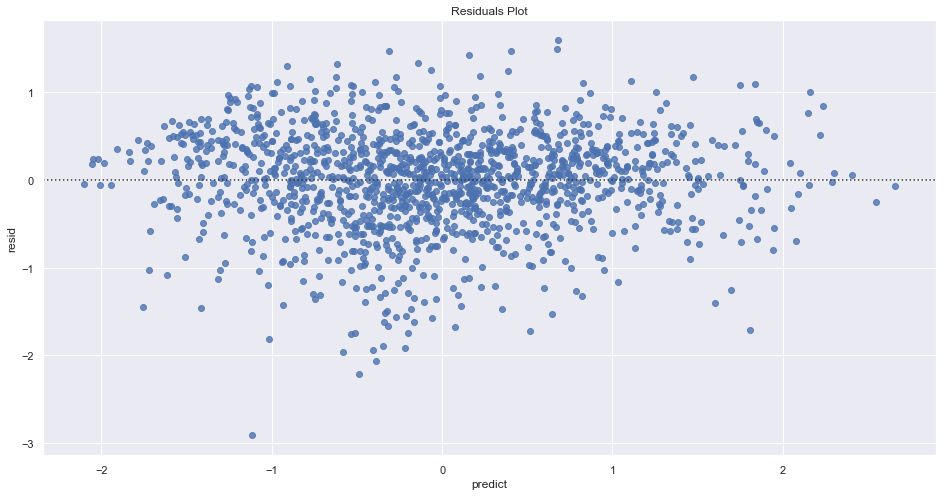

In [9]:
# Plot residuals
plt.figure(figsize=(16, 8))
sns.residplot('predict', 'resid', data=hw_residuals)
plt.title("Residuals Plot")
plt.show()  

In [10]:
# Shapiro-Wilk Test
stat, p = shapiro(hw_residuals['resid'])
alpha = 0.05
print('Shapiro-Wilk Test Results')
print('Statistics: {}, P-Value: {}'.format(round(stat, 3), round(p, 3)))
if p > alpha:
    print('Data looks normal (Fail to Reject H0)')
else: 
    print('Data does not look normal (Reject H0)')
print()

Shapiro-Wilk Test Results
Statistics: 0.975, P-Value: 0.0
Data does not look normal (Reject H0)



In [11]:
# D'Agostino's K^2 Test
stat, p = normaltest(hw_residuals['resid'])
alpha = 0.05
print("D'Agostino/Pearson Test Results")
print('Statistics: {}, P-Value: {}'.format(round(stat, 3), round(p, 3)))
if p > alpha:
    print('Data looks normal (Fail to Reject H0)')
else: 
    print('Data does not look normal (Reject H0)')
print()

D'Agostino/Pearson Test Results
Statistics: 128.638, P-Value: 0.0
Data does not look normal (Reject H0)



### Observations
- The plot and normality tests look pretty much identical to the OLS regression, so Huber-White doesn't seem to have helped.
- __Let's just proceed with standard OLS__. Though there seems to be heteroscedasticity from a plot perspective it doesn't appear terribly dramatic. 

## Sklearn Modeling - OLS
- Simple OLS using sklearn
- Sklearn has some additional tools and functionality that StatsModels lacks, so we'll be using this going forward. 
    

In [12]:
# Simple linear model in sklearn without train test split
lr = LinearRegression()
# Features df
X = df.iloc[:, 1:]
# Target df
y = df.iloc[:, 0]
# Fit the linear model
lr.fit(X, y)
# R2 Score
print('All Varialbes R2 Score: {}'.format(lr.score(X, y)))
print('Intercept: {}'.format(lr.intercept_))
print('Coefficients: {}'.format(lr.coef_))

All Varialbes R2 Score: 0.6912473087848793
Intercept: -0.05450189646288068
Coefficients: [-0.38918551 -0.02333501  0.61045839  0.04356543  0.02511054 -0.02623875
  0.58353172 -0.09044882  0.22816483  0.46955652  0.23022826 -0.00344651
 -0.23507091  0.29242505 -0.03923656  0.261387   -0.02178199  0.09506991
  0.03802693  0.14154157  0.175454   -0.00643429  0.08810269 -0.1680163
 -0.3284641   0.03411607 -0.2006206  -0.3502559 ]


- Same $R^{2}$ as StatsModels. 

## Split and Validate
- Time to use the train, validate and test methods to start evaluating the data. 
- It will be critical at this point to __split out the test data and not touch it until we're ready to run our final model__. 

In [13]:
# Split train-validate and test sets 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### __Train-Validate DF = df_val__

In [14]:
# Create train-validate df
df_val = pd.concat([y_train, X_train], axis=1)

### __Test DF = df_test__

In [15]:
# Create test df
df_test = pd.concat([y_test, X_test], axis=1)

### Train and Validate 
- Train and validate on test set. With test size set to 0.25 this will create a 60/20/20 train/validate/test split overall

In [16]:
# Use split and validate train-validate df with 75/25 train-validate split
regression.split_and_validate(df_val, test_size=0.25)

Validation R2 Score: 0.6860340533782777
Feature Coefficients: 

budget : -0.41
user_rating : -0.01
user_votes : 0.59
metacritic : 0.05
runtime : 0.04
articles : -0.03
opening_ratio : 0.59
Action : -0.03
Adventure : 0.31
Animation : 0.32
Biography : 0.11
Comedy : 0.07
Crime : -0.25
Documentary : 0.35
Drama : 0.01
Family : 0.18
Fantasy : 0.01
History : 0.14
Horror : 0.05
Music : 0.16
Musical : 0.07
Mystery : -0.02
Romance : 0.09
SciFi : -0.22
Sport : -0.26
Thriller : 0.01
War : -0.26
Western : -0.26


- Score remains about the same at __$R^{2}=$0.686__ 

## Interaction & Polynomioals
- Let's look at the pairplot of the remaining non-genre columns to see if there is potential for any interaction or polynomial terms to improve prediction.

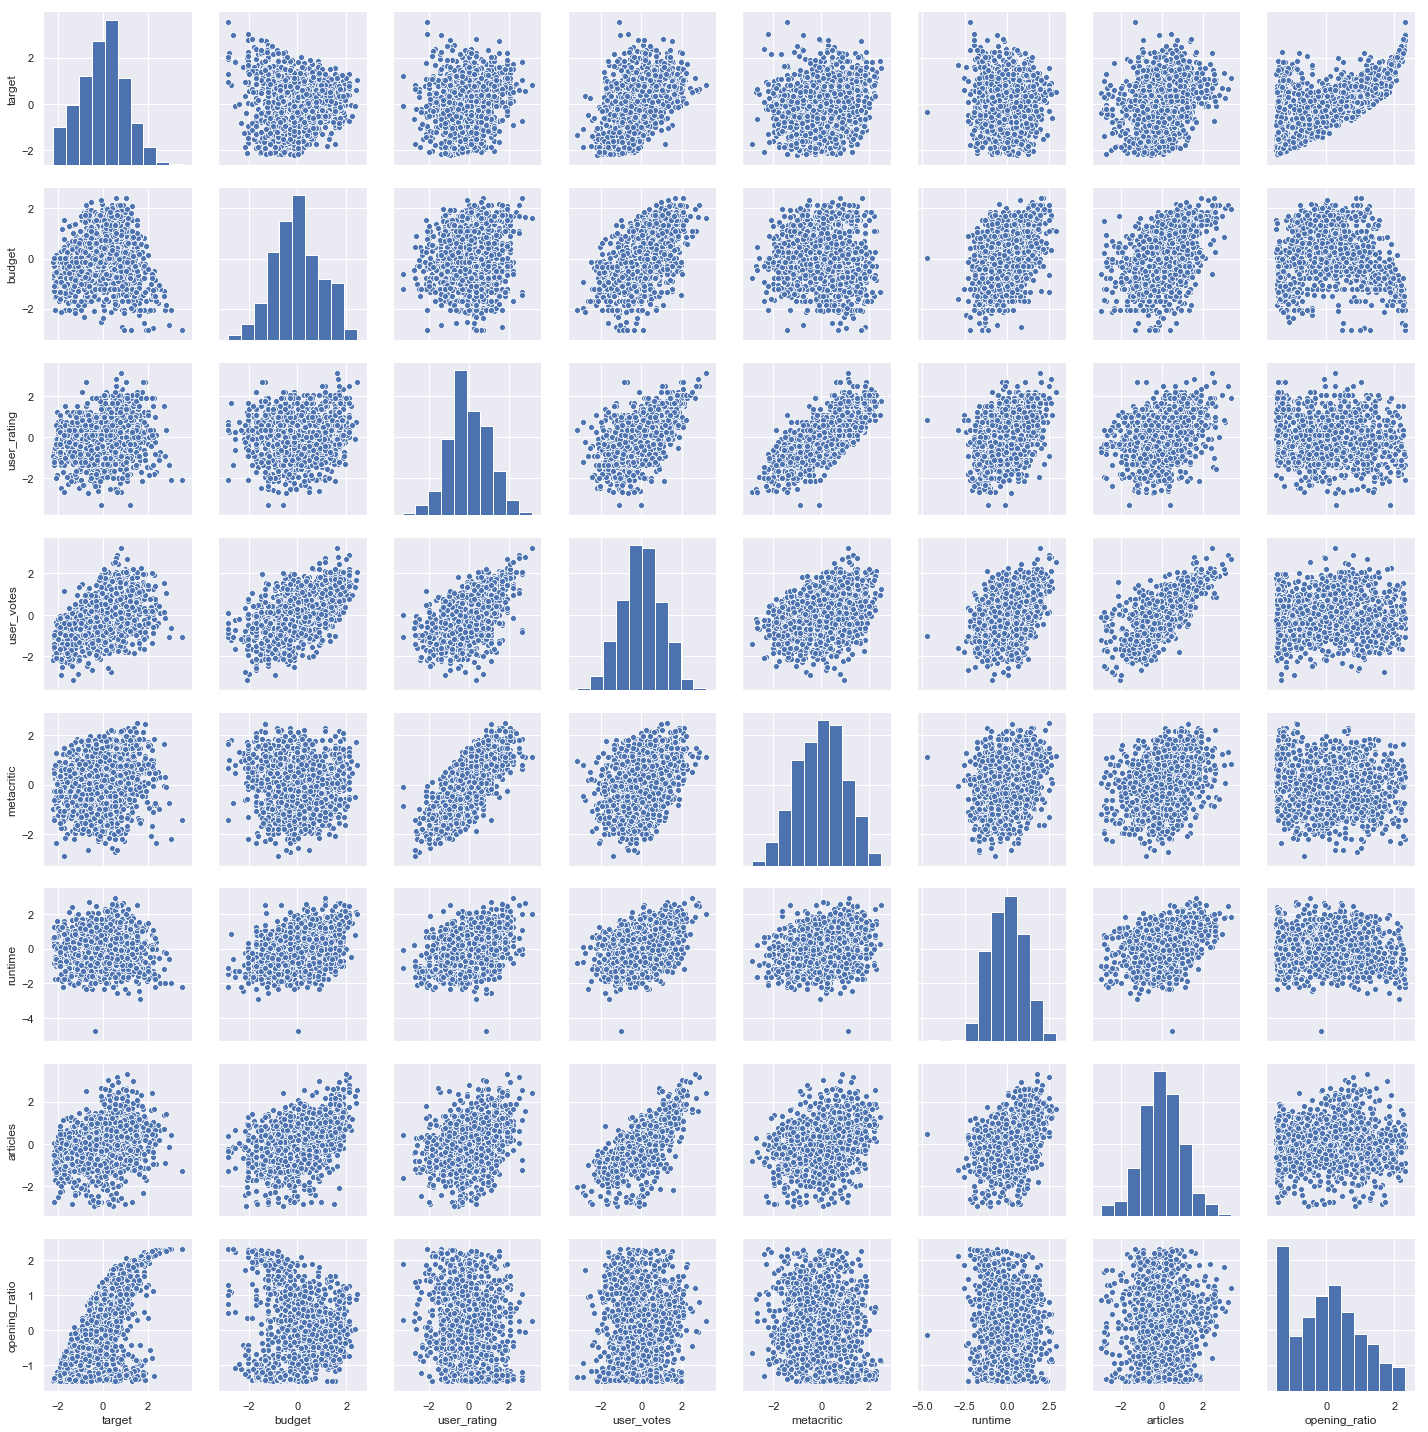

In [17]:
sns.pairplot(df.iloc[:, :8])

- Looks like there's some potential here for perhaps taking the __square of opening__.

### Add opening_ratio^2 column

In [18]:
df = df.copy()
df['opening_ratio^2'] = df['opening_ratio'] ** 2
regression.split_and_validate(df)

Validation R2 Score: 0.6555111730544533
Feature Coefficients: 

budget : -0.36
user_rating : -0.02
user_votes : 0.60
metacritic : 0.03
runtime : 0.02
articles : -0.03
opening_ratio : 0.56
Action : -0.04
Adventure : 0.27
Animation : 0.40
Biography : 0.19
Comedy : 0.06
Crime : -0.24
Documentary : 0.24
Drama : -0.02
Family : 0.24
Fantasy : -0.02
History : 0.09
Horror : -0.01
Music : 0.20
Musical : 0.16
Mystery : -0.01
Romance : 0.07
SciFi : -0.18
Sport : -0.33
Thriller : 0.02
War : -0.30
Western : -0.31
opening_ratio^2 : 0.11


- Interestingly this made things worse! __Let's drop the opening_ratio^2 column__.

In [19]:
df.drop(columns=['opening_ratio^2'], inplace=True)

### Split-Validate Observations
- Overall the $R^{2}$ is remaining stable at about 0.68 with train and validate.
- It remains to be seen how this will perform on test. 
- The __coefficients imply that there are several features that have a positive impact on the target__:
    - user_votes, metacritic, runtime, opening_ratio, Adventure, Animation, Biography, Comedy, Documentary, Family, History, Thriller.
- What is interesting is that __budget and user_rating are negatively correlated with the target__ and __opening_ratio__ and __user_votes__ are of about __equal value__.
- Now let's move on to regularization to see what effects this could have on the features.

## Regularization
- Another approach that helps to reduce the amount of extraneous variables and punishes too much complexity is regularization.
- There are two regularization techniques we'll use: Ridge and LASSO

### LASSO Regularization
- Penalizes complexity based upon the absolute value of the coefficients. This tends to reduce coefficients to zero, effectively eliminating them. 
- LASSO helps with creating a model that is more interpretable, since there can be fewer features to parse.
- However, there is a risk of eliminating features that are actually useful.

In [20]:
df.head()

,target,budget,user_rating,user_votes,metacritic,runtime,articles,opening_ratio,Action,Adventure,...,Horror,Music,Musical,Mystery,Romance,SciFi,Sport,Thriller,War,Western
0,0.965026,0.638084,2.082153,2.187319,1.394274,2.009062,1.658083,0.742359,0,0,...,0,0,0,1,0,0,0,1,0,0
1,1.224131,1.613356,0.856932,1.005773,0.630255,1.221424,0.843410,1.337181,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0.992885,-0.506460,1.246698,0.625065,1.607960,1.481443,0.608801,0.918530,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.070181,1.864589,0.984803,1.793567,1.872503,1.439673,2.257574,1.262511,1,1,...,0,0,0,0,0,1,0,0,0,0
4,1.061449,0.125333,1.380737,1.432379,1.767017,0.397793,0.596589,0.723505,1,0,...,0,0,0,0,0,0,0,0,0,0


#### Split into train, test and validate dfs

In [21]:
# Split 
X = df.iloc[:, 1:] # Features
y = df.iloc[:, 0] # Target

#### Train/Validation/Test sets = X_train, X_val, X_test, y_train, y_val, y_test

In [22]:
# Create 60/20/20 train/validate/test splits
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [23]:
# Alpha = 10
lasso_model = Lasso(alpha = 10) 
lasso_model.fit(X_train, y_train)
list(zip(X_train, lasso_model.coef_))

[('budget', -0.0),
 ('user_rating', 0.0),
 ('user_votes', 0.0),
 ('metacritic', 0.0),
 ('runtime', -0.0),
 ('articles', 0.0),
 ('opening_ratio', 0.0),
 ('Action', -0.0),
 ('Adventure', 0.0),
 ('Animation', 0.0),
 ('Biography', -0.0),
 ('Comedy', 0.0),
 ('Crime', -0.0),
 ('Documentary', 0.0),
 ('Drama', -0.0),
 ('Family', -0.0),
 ('Fantasy', -0.0),
 ('History', -0.0),
 ('Horror', 0.0),
 ('Music', 0.0),
 ('Musical', -0.0),
 ('Mystery', 0.0),
 ('Romance', -0.0),
 ('SciFi', 0.0),
 ('Sport', -0.0),
 ('Thriller', 0.0),
 ('War', -0.0),
 ('Western', -0.0)]

- Seems the regularization is a little too aggressive. Let's reduce it...

In [24]:
# Alpha = 0.5
lasso_model = Lasso(alpha = 0.5) 
lasso_model.fit(X_train, y_train)
list(zip(X_train, lasso_model.coef_))

[('budget', -0.0),
 ('user_rating', 0.0),
 ('user_votes', 0.0),
 ('metacritic', 0.0),
 ('runtime', -0.0),
 ('articles', 0.0),
 ('opening_ratio', 0.157833773360531),
 ('Action', -0.0),
 ('Adventure', 0.0),
 ('Animation', 0.0),
 ('Biography', -0.0),
 ('Comedy', -0.0),
 ('Crime', -0.0),
 ('Documentary', 0.0),
 ('Drama', -0.0),
 ('Family', -0.0),
 ('Fantasy', -0.0),
 ('History', -0.0),
 ('Horror', 0.0),
 ('Music', 0.0),
 ('Musical', -0.0),
 ('Mystery', 0.0),
 ('Romance', -0.0),
 ('SciFi', 0.0),
 ('Sport', -0.0),
 ('Thriller', 0.0),
 ('War', -0.0),
 ('Western', -0.0)]

#### opening_ratio is the most important feature

- Though regularization is still a bit too strong here, it does clearly show that __opening_ratio is the most important feature__. Not surprising, but worthy of note. 


### Ridge Regularization
- Ridge also penalizes complexity, but pushes towards zero as opposed to reducing coefficients completely to zero. 
- Great for smoothing out multicollinearity, and working with sparse/few featues
- However, will never fully discard features even if they are effectively useless.

In [25]:
ridge_model = Ridge(alpha = 10000000) 
ridge_model.fit(X_train, y_train)
list(zip(X_train, ridge_model.coef_))

[('budget', -5.627171449789082e-06),
 ('user_rating', 1.749216256465072e-05),
 ('user_votes', 3.496413446311928e-05),
 ('metacritic', 1.5709356912321856e-05),
 ('runtime', -3.1363090431920086e-06),
 ('articles', 2.2806918028817415e-05),
 ('opening_ratio', 5.622207539160539e-05),
 ('Action', -1.2572066277135584e-06),
 ('Adventure', 2.414117317786346e-06),
 ('Animation', 1.512055433681638e-06),
 ('Biography', -2.649741522694301e-06),
 ('Comedy', 9.28529049227617e-08),
 ('Crime', -4.5046595060882055e-06),
 ('Documentary', 4.6985092730936695e-08),
 ('Drama', -7.516013946239176e-06),
 ('Family', -2.7567625489559684e-08),
 ('Fantasy', -2.3445603991026594e-07),
 ('History', -1.1128542177798014e-06),
 ('Horror', 6.289113217419201e-06),
 ('Music', 7.155116861039774e-07),
 ('Musical', -1.6550709433776301e-07),
 ('Mystery', 4.478390341994135e-06),
 ('Romance', -9.651662241456007e-07),
 ('SciFi', 4.080298480804658e-07),
 ('Sport', -3.615070508671607e-07),
 ('Thriller', 3.3064437111148984e-06),
 ('

- As with LASSO user_votes and opening_ratio have the highest positive coefficients, but none of the features are reduced to zero. 

### Test the LASSO model

In [26]:
# Predictions of LASSO on test set
test_set_pred = lasso_model.predict(X_val)

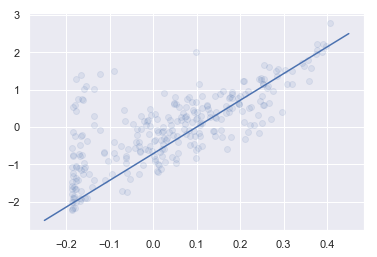

In [27]:
plt.scatter(test_set_pred, y_val, alpha=.1)
plt.plot(np.linspace(-0.25,0.45), np.linspace(-2.5, 2.5))

In [28]:
r2_score(y_val, test_set_pred)

0.19995719068215345

- Wow, that prediction is awful! Proably due to the Alpha, but can't know for sure until we test more. Let's look at the validation set with regularization.

### Define Mean Absolute Error (MAE) = mae(y_true, y_pred)

In [29]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))
mae(y_val, test_set_pred)

0.7153153463077297

### Standard Scale Features
- __Always apply standard scaling for regularization!__

In [30]:
# Fit transformation 
scaler = StandardScaler()
scaler.fit(X_train.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

#### Scaled training/validation/test features = X_train_ss, X_val_ss, X_test_ss

In [31]:
# Note that the transformed data is an np.array
# Also note that we are only scaling the training features, not the training target
X_train_ss = scaler.transform(X_train.values)
X_val_ss = scaler.transform(X_val.values)
X_test_ss = scaler.transform(X_test.values)

In [32]:
lasso_model_ss = Lasso(alpha = 0.5)
lasso_model_ss.fit(X_train_ss, y_train)
list(zip(X_train.columns, lasso_model_ss.coef_))

[('budget', -0.0),
 ('user_rating', 0.0),
 ('user_votes', 0.0),
 ('metacritic', 0.0),
 ('runtime', -0.0),
 ('articles', 0.0),
 ('opening_ratio', 0.15476390700588552),
 ('Action', -0.0),
 ('Adventure', 0.0),
 ('Animation', 0.0),
 ('Biography', -0.0),
 ('Comedy', -0.0),
 ('Crime', -0.0),
 ('Documentary', 0.0),
 ('Drama', -0.0),
 ('Family', -0.0),
 ('Fantasy', -0.0),
 ('History', -0.0),
 ('Horror', 0.0),
 ('Music', 0.0),
 ('Musical', -0.0),
 ('Mystery', 0.0),
 ('Romance', -0.0),
 ('SciFi', 0.0),
 ('Sport', -0.0),
 ('Thriller', 0.0),
 ('War', -0.0),
 ('Western', -0.0)]

- No difference with standard scaling but that's fine.

## Tuning Regularization with Validation (and Pipelines!)


In [33]:
# List of alpha values
alphalist = 10 ** (np.linspace(-4,0,200))
# Empty array of equal size to alphalist for validation set
err_vec_val = np.zeros(len(alphalist))
# Empty array of equal size to alphalist for training set
err_vec_train = np.zeros(len(alphalist))

In [34]:
for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train_ss, y_train)
    
    val_set_pred = pipe.predict(X_val_ss)
    err_vec_val[i] = mae(y_val, val_set_pred)

### Plot Mean Absolute Error

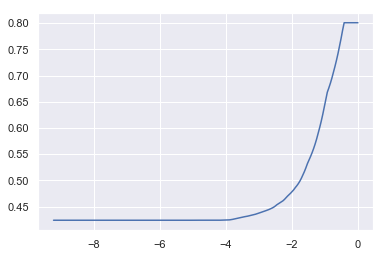

In [35]:
plt.plot(np.log(alphalist), err_vec_val)

### What is the smallest error and the alpha for that value?

In [36]:
# Return smallest error
np.min(err_vec_val)

0.42354987587841053

In [37]:
# Return alpha value for minimum error 
alphalist[np.argmin(err_vec_val)]

0.0023272024789604074

### Validate LASSO Model with Best Alpha

In [38]:
# Alpha = 0.0023272024789604074
lasso_model = Lasso(alpha = 0.0023272024789604074) 
lasso_model.fit(X_train_ss, y_train)
list(zip(X_train, lasso_model.coef_))

[('budget', -0.4322859001745289),
 ('user_rating', -0.0),
 ('user_votes', 0.5798651985555736),
 ('metacritic', 0.04673838369819654),
 ('runtime', 0.01313694165403071),
 ('articles', -0.0025791832045857885),
 ('opening_ratio', 0.5855332014735946),
 ('Action', -0.005681655172451599),
 ('Adventure', 0.11717941191213546),
 ('Animation', 0.11102019120437712),
 ('Biography', 0.04739979702983676),
 ('Comedy', 0.026485196998695962),
 ('Crime', -0.09963052293934448),
 ('Documentary', 0.034123220530206604),
 ('Drama', -0.0),
 ('Family', 0.042646948624753385),
 ('Fantasy', 0.0),
 ('History', -0.00856348902702944),
 ('Horror', 0.010302660130650412),
 ('Music', 0.04494503721819125),
 ('Musical', 0.012441646545623936),
 ('Mystery', -0.00040984931807460425),
 ('Romance', 0.014259077562539097),
 ('SciFi', -0.06137784125103309),
 ('Sport', -0.027873700426245394),
 ('Thriller', -0.0),
 ('War', -0.02475653337864521),
 ('Western', -0.02516379828424097)]

- Notice how many fewer coefficients are zeroed out. 

In [39]:
# Predictions of LASSO on test set
test_set_pred = lasso_model.predict(X_val_ss)

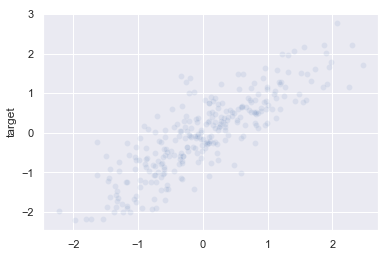

In [40]:
sns.scatterplot(test_set_pred, y_val, alpha=.1)

In [41]:
lasso_mae = mae(y_val, test_set_pred)
lasso_mae

0.42354987587841053

In [43]:
lasso_r2_score = r2_score(y_val, test_set_pred)
lasso_r2_score

0.7007427385388312

### LASSO Validation Result: $R^{2}$ = 0.7001, MAE = 0.4235

### Try with Ridge Regression

In [44]:
# List of alpha values
alphalist = 10 ** (np.linspace(-4,4,200))
# Empty array of equal size to alphalist for validation set
err_vec_val = np.zeros(len(alphalist))
# Empty array of equal size to alphalist for training set
err_vec_train = np.zeros(len(alphalist))

In [45]:
for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('ridge', Ridge(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train_ss, y_train)
    
    val_set_pred = pipe.predict(X_val_ss)
    err_vec_val[i] = mae(y_val, val_set_pred)

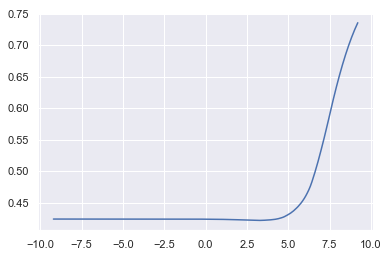

In [46]:
plt.plot(np.log(alphalist), err_vec_val)

In [47]:
# Minimum error
np.min(err_vec_val)

0.4217929207308184

In [48]:
# Return alpha value of minimum error
alphalist[np.argmin(err_vec_val)]

24.37444150122222

### Validate Ridge Model with Best Alpha

In [76]:
# Alpha = 24.37444150122222
ridge_model = Ridge(alpha = 24.37444150122222) 
ridge_model.fit(X_train_ss, y_train)
list(zip(X_train, ridge_model.coef_))

[('budget', -0.38505521324635794),
 ('user_rating', 0.017650448007199428),
 ('user_votes', 0.5209602049062989),
 ('metacritic', 0.057811674439958986),
 ('runtime', 0.007357975157867944),
 ('articles', 0.013182723654449434),
 ('opening_ratio', 0.5770098376965093),
 ('Action', -0.010706886855022621),
 ('Adventure', 0.10830343329404987),
 ('Animation', 0.09880109736274784),
 ('Biography', 0.04407342535852161),
 ('Comedy', 0.026428408534887288),
 ('Crime', -0.09723698616921236),
 ('Documentary', 0.031143031868101644),
 ('Drama', -0.006970260093975978),
 ('Family', 0.0368979926964779),
 ('Fantasy', -0.001432298427804753),
 ('History', -0.01284308312448973),
 ('Horror', 0.021684132322539885),
 ('Music', 0.04587770568025981),
 ('Musical', 0.011315956784329059),
 ('Mystery', 0.0018489315368741778),
 ('Romance', 0.016518942740397276),
 ('SciFi', -0.06090895135224959),
 ('Sport', -0.03045382058677612),
 ('Thriller', 0.0007908350882127998),
 ('War', -0.027389023928097653),
 ('Western', -0.0279079

In [77]:
# Predictions of LASSO on test set
test_set_pred = ridge_model.predict(X_val_ss)

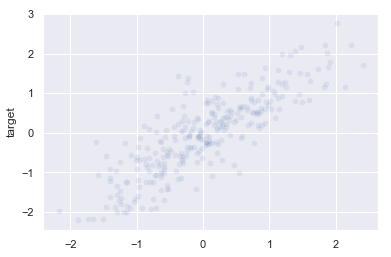

In [78]:
sns.scatterplot(test_set_pred, y_val, alpha=.1)

In [79]:
ridge_mae = mae(y_val, test_set_pred)
ridge_mae

0.4217929207308182

In [80]:
ridge_r2_score = r2_score(y_val, test_set_pred)
ridge_r2_score

0.7025712911682821

### Ridge Test Result: $R^{2}$ = 0.7026, MAE = 0.04217

## Automated Regularization with Cross-Validation
- Use sklearn's automated cross-validation for Ridge and LASSO regression to find the optimal alpha regularization value and to make the model more generalizable. 

### Lasso Cross-Validation to find the optimal Alpha 

In [54]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-4,4,400)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train_ss, y_train)

LassoCV(alphas=array([1.00000e-04, 1.04725e-04, ..., 9.54882e+03, 1.00000e+04]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [55]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
lasso_model.alpha_

0.013344837298838383

In [56]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train.columns, lasso_model.coef_))

[('budget', -0.38049902595841967),
 ('user_rating', 0.0),
 ('user_votes', 0.5365097112298864),
 ('metacritic', 0.056753843062080186),
 ('runtime', -0.0),
 ('articles', 0.0),
 ('opening_ratio', 0.5813639024941539),
 ('Action', -0.01073737221477163),
 ('Adventure', 0.08822598410656698),
 ('Animation', 0.09525852321253715),
 ('Biography', 0.023443216984079567),
 ('Comedy', 0.009502511833358469),
 ('Crime', -0.09588028129713204),
 ('Documentary', 0.021508526159650616),
 ('Drama', -0.0),
 ('Family', 0.025565425013579897),
 ('Fantasy', -0.0),
 ('History', -0.0),
 ('Horror', 0.0),
 ('Music', 0.0362199202693439),
 ('Musical', 0.0),
 ('Mystery', -0.0),
 ('Romance', 0.0),
 ('SciFi', -0.05257165833065864),
 ('Sport', -0.01690675356308162),
 ('Thriller', -0.0),
 ('War', -0.01604865568935744),
 ('Western', -0.01594309893555782)]

In [57]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_val_ss)

In [58]:
# Find the MAE and R^2 on the test set using this model
lassoCV_mae = mae(y_val, test_set_pred)
lassoCV_mae

0.42382831148468825

In [59]:
lassoCV_r2_score = r2_score(y_val, test_set_pred)
lassoCV_r2_score

0.7053213404384538

### Lasso Cross-Validation $R^{2}$ = 0.7053, MAE = 0.4238

### Ridge Cross-Validation

In [60]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-4,4,400)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_train_ss, y_train)

RidgeCV(alphas=array([1.00000e-04, 1.04725e-04, ..., 9.54882e+03, 1.00000e+04]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [61]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
ridge_model.alpha_

5.149670581618343

In [62]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train.columns, ridge_model.coef_))

[('budget', -0.434984996206095),
 ('user_rating', -0.013250384616792638),
 ('user_votes', 0.5885299746387983),
 ('metacritic', 0.05589002002440919),
 ('runtime', 0.020448327248501923),
 ('articles', -0.009872153686444368),
 ('opening_ratio', 0.5827375663186928),
 ('Action', -0.005496307811823369),
 ('Adventure', 0.12103472064204307),
 ('Animation', 0.11407598678119046),
 ('Biography', 0.05199499380145575),
 ('Comedy', 0.029198946447228268),
 ('Crime', -0.09932989471956405),
 ('Documentary', 0.037747023769163224),
 ('Drama', 0.00015608485468499128),
 ('Family', 0.04581306191888484),
 ('Fantasy', 0.0005291109651399388),
 ('History', -0.011465751192965707),
 ('Horror', 0.0160173113763076),
 ('Music', 0.0465354089466235),
 ('Musical', 0.014906796705317932),
 ('Mystery', -0.0023800811083773835),
 ('Romance', 0.01809182407995935),
 ('SciFi', -0.06273859526343037),
 ('Sport', -0.030086036098256795),
 ('Thriller', 0.00030265065571464503),
 ('War', -0.027237090454648515),
 ('Western', -0.026932

In [62]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_val_ss)

In [63]:
# Find the MAE and R^2 on the test set using this model
ridgeCV_mae = mae(y_val, test_set_pred)
ridgeCV_mae

0.42382831148468825

In [64]:
ridgeCV_r2_score = r2_score(y_val, test_set_pred)
ridgeCV_r2_score

0.7053213404384538

### Ridge Cross-Validation $R^{2}$ = 0.7053, MAE = 0.4238

## Create Validation Results Dataframe = regression_results_df

In [65]:
results_dict = {'models': ['Ridge', 'Lasso', 'RidgeCV', 'LassoCV'],
                'r2_scores':[ridge_r2_score, lasso_r2_score, ridgeCV_r2_score, lassoCV_r2_score], 
                'mean_absolute_errors': [ridge_mae, lasso_mae, ridgeCV_mae, lassoCV_mae]}

In [66]:
regression_results_df = pd.DataFrame(results_dict)
regression_results_df.sort_values(by='mean_absolute_errors').reset_index(drop=True)

,models,r2_scores,mean_absolute_errors
0,Ridge,0.702571,0.421793
1,Lasso,0.700743,0.423550
2,RidgeCV,0.705321,0.423828
3,LassoCV,0.705321,0.423828


### Validation Results
- A few interesting results here. 
    - Overall the scores were very close for all methods, in terms of both R-Squared and MAE.
    - RidgeCV and LassoCV had the identical results. 
    - Ridge/LassoCV has the best performance in terms of R-Squared scores, but Ridge had the smallest MAE
- So then the key decision is which model to take. Because MAE is a more objective measure of a model's predictive power, we'll use MAE to make our decision instead of R-Squared. As such __we'll use Ridge with the optimal Alpha value to do the final test on our data.__

## Apply Ridge Model to Test Data

In [73]:
# Predictions of LASSO on test set
final_test_set_pred = ridge_model.predict(X_test_ss)

In [74]:
ridge_mae_test = mae(y_test, test_set_pred)
ridge_mae_test

0.45725365490138065

In [75]:
ridge_r2_score_test = r2_score(y_test, final_test_set_pred)
ridge_r2_score_test

0.6404123150603942

### FINAL TEST RESULT - Ridge Regularization: $R^{2}$ = 0.6404, MAE = 0.4573

## Conclusions

### Validation Results

In [81]:
# Testing Results
regression_results_df.sort_values(by='mean_absolute_errors', ascending=True)

,models,r2_scores,mean_absolute_errors
0,Ridge,0.702571,0.421793
1,Lasso,0.700743,0.423550
2,RidgeCV,0.705321,0.423828
3,LassoCV,0.705321,0.423828


- All of the methods produced __roughly the same results__.
- Of the modeling methods attempted normal train/test/split __Ridge produced the best result in terms of MAE: $R^{2}=0.7026$, MAE = 0.4217__.

### Test Results - Ridge Regularization: $R^{2}$ = 0.6404, MAE = 0.4573

- There was a significant but not unexpected drop in performance on test versus validation 
    - R-Squared: -0.06
    - MAE: +0.03
- These numbers are not great, so __we definitely have more work to do in terms of finding features and possibly models to improve the prediction.__

### Features & Coefficients

In [83]:
# Alpha = 24.37444150122222
alphavec = 10**np.linspace(-4,4,400)

ridge_model = Ridge(alpha = 24.37444150122222)
ridge_model.fit(X_train_ss, y_train)
test_set_pred = ridge_model.predict(X_test_ss)
pd.DataFrame({'Feature': list(X_train), 'Coefficients': list(ridge_model.coef_)}).sort_values(by='Coefficients', ascending=False).head(10)

,Feature,Coefficients
6,opening_ratio,0.577010
2,user_votes,0.520960
8,Adventure,0.108303
9,Animation,0.098801
3,metacritic,0.057812
19,Music,0.045878
10,Biography,0.044073
15,Family,0.036898
13,Documentary,0.031143
11,Comedy,0.026428


- opening_ratio and user_votes has the highest positive coefficients across all models, followed by metacritic, user_rating and articles interspersed with some genres. Of note is that __certain genres are more important than rating metrics like metacritic and user_rating.
- However __opening_ratio__ and __user_votes__ far outpace everthing below them in terms of importance.
- Though many methods were employed we weren't able to get complete normality in the features or residuals, though there were significant improvements using __Yeo-Johnson transformation__. 
- Throught the process of eliminating features that aren't available before release we've discovered that:
    1. It is difficult to do a prediction with any kind of accuracy with only those features available before movie release. 
    2. The features such as metacritic, user_rating, user_votes, opening, and opening_ratio matter a great deal to the predictive power of the model.
    3. There may be other features such as the MOVIEmeter rating at release, the MOVIEmeter trajectory from announce to release, the STARmeter rating of the principal cast and director at release, and the financial performance of the films the principal players have been before release that may be better predictors.

### Future Work
- __Incorporate STARmeter, MOVIEmeter, and historical film performance metrics of the principals before release into the modeling. Hopefully this will improve prediction as well as make the model more useful as a pre-launch prediction tool.__ 